## Estimate generalization error of Random feature model 

Population error: for each p-value(p=4,6,8,10,12,14,16,18,20), generate batch_size=100 test sets S', take 1000 w, calculate the average MSE.\
Empirical error: error on training set, that is generated (S,w) data for each p-value.\
Generalization error: population error - empirical error.

### data

In [31]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import json
from Sample_Gibbs_from_Gaussian import sample_w
from Sample_Gibbs_from_Gaussian import sample_w_ori
from Sample_Gibbs_from_Gaussian import minimized_w
import os
beta = 10
sigma_q = 0.5
'''
os.chdir('C://Users//sunji//Documents//WeChat Files//wxid_rjlp06765c5a21//FileStorage//File//2023-10')
os.listdir('data')
'''

"\nos.chdir('C://Users//sunji//Documents//WeChat Files//wxid_rjlp06765c5a21//FileStorage//File//2023-10')\nos.listdir('data')\n"

In [32]:
'''
for p_current in range(4,22,2):
    with open('data/gibbs_data_p_is_{}.json'.format(p_current), 'r') as datafile:
        data = json.load(datafile)
    print(len(data))
    '''

"\nfor p_current in range(4,22,2):\n    with open('data/gibbs_data_p_is_{}.json'.format(p_current), 'r') as datafile:\n        data = json.load(datafile)\n    print(len(data))\n    "

### population error

In [33]:
original_random_state = np.random.get_state()
np.random.seed(20230929) 
#gaussian distribution sampler: normal(mean=0.0, variance_sqrt=1.0, size=None) s = np.random.normal(0,1)
#teacher model
#dimension of x: d（固定不变）10->5
d = 5
#number of training samples（固定不变）100->20
N = 20
#dimension of hypothesis space
p0 = 5 #dimension of teacher model（固定不变）
#p = p #dimension of student model（可变）#p=200
p_max = 2000 #upper bound of dimension of student model（固定不变）
#point-wise activate function f:tanh
#variance of random noise added to y
sigma = 0.1

#random feature matrix
F0 = np.random.normal(0,1,(d,p0)) #生成teacher model的random feature matrix F0（固定不变）
F_ = np.random.normal(0,1,(d,p_max)) #生成student model的random feature matrix F(d*p)。先按照p_max的大小生成，再根据当前维度p的不同截取前p列形成每个p对应的F。
    #注意，这个F对于一般的神经网络是可训练的，但是对于RFM为了简化直接设定为固定值。（固定不变）
#teacher parameter w(p) with lambda = ? until each dim of Y~1e0
lambda_ = 0.0001
#w_0 = np.random.normal(0,sigma/np.sqrt(lambda_*N),p)
w_0 = np.random.normal(0,1,p0) #生成teacher model的权重向量（固定不变）
#w_0 = np.concatenate((w_0,np.zeros(5)),axis = 0)

np.random.set_state(original_random_state)
def population_MSE(p,w_num,batch_size=100):
    """ Estimate population error of Random feature model.
    
    :param w_list: list of generated w for estimation 
    :param p: dimension of student model（可变）
    :param batch_size: number of test dataset S'
    :return: float, MSE for population error
    """

    """
    参数设置：与训练所用teacher model保持一致（来自09-29: Gibbs.py）
    """
    F = F_[:,:p]
    np.random.seed(20231004+p) #每个p用不同的随机种子,对应不同固定随机的测试集
    
    MSE_list=[]
    for i_ in range(w_num):
        X = np.random.normal(0,1,(N,d))
        X_rf0 = np.tanh(X.dot(F0)/np.sqrt(d))
        Y_pure = X_rf0.dot(w_0)
        Y = Y_pure + np.random.normal(0,sigma,N) #由X通过teacher model（也就是F0和w_0）生成的Y
        #S_i = np.concatenate((X,Y.reshape(N,-1)),axis=1).reshape(-1)  #S=(X,Y)[0]
        B = np.tanh(X.dot(F)/np.sqrt(d))
        lambda_ = 1/(2*sigma_q**2*beta)
        #lambda_ = 0.1
        sigma_sq = N/(2*beta)
        w = sample_w_ori(p,N,lambda_,sigma_sq,B,Y)[0]  
        #w = minimized_w(p,N,lambda_,B,Y)
        '''
        采样测试集S'：每次测试集重新生成，此处采样一个S=(X,Y)
                采样X(N*d)，X经过F0和w_0作用后再加上高斯扰动（这个扰动是必要的，不然构成确定映射不影响互信息）形成Y，
                Y与X一起构成了从dataset里采样的N个样本，对应了论文中的=>S （可变）
        '''
        #samples X(N*d) 
        X = np.random.normal(0,1,(batch_size,d)) #生成N个d维随机向量，作为N条样本组成的训练集。
        #X after the random feature matrix
        X_rf0 = np.tanh(X.dot(F0)/np.sqrt(d))
        Y_pure = X_rf0.dot(w_0)
        Y = Y_pure + np.random.normal(0,sigma,batch_size) #由X通过teacher model（也就是F0和w_0）生成的Y

        '''
        w预测：X经过F和w_0作用形成pred_Y，泛化误差mse:E[（Y-pred_Y）^2]
        '''
        X_rf = np.tanh(X.dot(F)/np.sqrt(d))
        diff = Y-X_rf.dot(w)
        MSE_list.append(diff.dot(diff)/batch_size)  #除一个训练集的样本数N
        
    return sum(MSE_list)/len(MSE_list)

In [34]:
w_num = 10000
test_size = 1000

population_error=[]
p_error = population_MSE(4,w_num,test_size)
p_error

0.3013560627699644

p=4: population error=0.3013560627699644
p=6: population error=0.29797030514577366
p=8: population error=0.2928692525884479
p=10: population error=0.3368662218302218
p=12: population error=0.3452094118548798
p=14: population error=0.35691317523023786
p=16: population error=0.3708632910877811
p=18: population error=0.39746079017847885
p=20: population error=0.41727059898090957
p=22: population error=0.4246649924050922
p=24: population error=0.43404027084857505
p=26: population error=0.4568826754960427
p=28: population error=0.4670741569741074
p=30: population error=0.4673518941983271


Text(0.5, 1.0, 'Population error (w_num = 1000,test_size = 1000)')

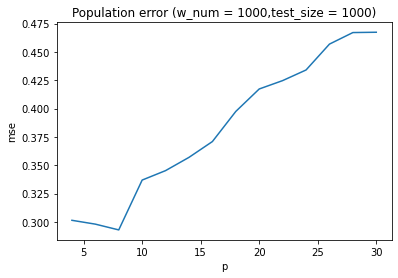

In [35]:
#param
w_num = 10000
test_size = 1000

population_error=[]

for p_current in range(4,32,2):

    p_error = population_MSE(p_current,w_num,test_size)
    population_error.append(p_error)
    print('p={}: population error={}'.format(p_current,p_error))


#plot
plt.plot(range(4,32,2), population_error)
plt.xlabel('p')
plt.ylabel('mse')
plt.title('Population error (w_num = 1000,test_size = 1000)')

### empirical error

In [36]:
def empirical_MSE(p,w_num):
    """ Culculate empirical error.
    
    :param data: list of generated (S,w), of which each element is a dictionary like {'S':xxx,'w':xxx}
    :param p: dimension of student model（variable）
    :return: float, MSE for empirical error.
    """

    """
    参数设置：与训练所用teacher model保持一致（来自09-29: Gibbs.py）
    """
    F = F_[:,:p]
    np.random.seed(20231004+p) #每个p用不同的随机种子,对应不同固定随机的测试集
    
    MSE_list=[]
    for i_ in range(w_num):
        X = np.random.normal(0,1,(N,d))
        X_rf0 = np.tanh(X.dot(F0)/np.sqrt(d))
        Y_pure = X_rf0.dot(w_0)
        Y = Y_pure + np.random.normal(0,sigma,N) #由X通过teacher model（也就是F0和w_0）生成的Y
        #S_i = np.concatenate((X,Y.reshape(N,-1)),axis=1).reshape(-1)  #S=(X,Y)[0]
        B = np.tanh(X.dot(F)/np.sqrt(d))
        lambda_ = 1/(2*sigma_q**2*beta)
        #lambda_ = 0.1
        sigma_sq = N/(2*beta)
        w = sample_w_ori(p,N,lambda_,sigma_sq,B,Y)[0]    
        #w = minimized_w(p,N,lambda_,B,Y)
        '''
        采样测试集S'：每次测试集重新生成，此处采样一个S=(X,Y)
                采样X(N*d)，X经过F0和w_0作用后再加上高斯扰动（这个扰动是必要的，不然构成确定映射不影响互信息）形成Y，
                Y与X一起构成了从dataset里采样的N个样本，对应了论文中的=>S （可变）
        '''

        '''
        w预测：X经过F和w_0作用形成pred_Y，泛化误差mse:E[（Y-pred_Y）^2]
        '''
        X_rf = np.tanh(X.dot(F)/np.sqrt(d))
        diff = Y-X_rf.dot(w)
        MSE_list.append(diff.dot(diff)/N)  #除一个训练集的样本数N
        
    return sum(MSE_list)/len(MSE_list)

p=4: empirical error=0.2521141050992815
p=6: empirical error=0.23906652944116089
p=8: empirical error=0.2322105035247926
p=10: empirical error=0.25572159895025204
p=12: empirical error=0.25949877479583366
p=14: empirical error=0.26628167780128714
p=16: empirical error=0.27237951660378723
p=18: empirical error=0.28352289798932384
p=20: empirical error=0.2908029325788194
p=22: empirical error=0.29706015774020905
p=24: empirical error=0.30030771741608636
p=26: empirical error=0.30829408759408156
p=28: empirical error=0.3104284096441244
p=30: empirical error=0.3124714244633856


Text(0.5, 1.0, 'Empirical error')

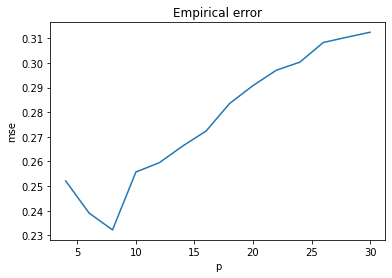

In [37]:
empirical_error=[]
for p_current in range(4,32,2):
    e_error = empirical_MSE(p_current,50000)
    empirical_error.append(e_error)
    print('p={}: empirical error={}'.format(p_current,e_error))

#plot
plt.plot(range(4,32,2), empirical_error)
plt.xlabel('p')
plt.ylabel('mse')
plt.title('Empirical error')

### generalization error

In [38]:
np.array(population_error)

array([0.30135606, 0.29797031, 0.29286925, 0.33686622, 0.34520941,
       0.35691318, 0.37086329, 0.39746079, 0.4172706 , 0.42466499,
       0.43404027, 0.45688268, 0.46707416, 0.46735189])

In [39]:
generalization_error=np.array(population_error) - np.array(empirical_error)
generalization_error

array([0.04924196, 0.05890378, 0.06065875, 0.08114462, 0.08571064,
       0.0906315 , 0.09848377, 0.11393789, 0.12646767, 0.12760483,
       0.13373255, 0.14858859, 0.15664575, 0.15488047])

In [40]:
empirical_error

[0.2521141050992815,
 0.23906652944116089,
 0.2322105035247926,
 0.25572159895025204,
 0.25949877479583366,
 0.26628167780128714,
 0.27237951660378723,
 0.28352289798932384,
 0.2908029325788194,
 0.29706015774020905,
 0.30030771741608636,
 0.30829408759408156,
 0.3104284096441244,
 0.3124714244633856]

In [41]:
population_error

[0.3013560627699644,
 0.29797030514577366,
 0.2928692525884479,
 0.3368662218302218,
 0.3452094118548798,
 0.35691317523023786,
 0.3708632910877811,
 0.39746079017847885,
 0.41727059898090957,
 0.4246649924050922,
 0.43404027084857505,
 0.4568826754960427,
 0.4670741569741074,
 0.4673518941983271]

In [42]:
import pandas as pd

df = pd.DataFrame([population_error,empirical_error,generalization_error],columns=range(4,32,2))
df.insert(0, 'Risk Type', ['population','empirical','generalization'])
df.to_csv('risk value.csv', index=False)
df

,Risk Type,4,6,8,10,12,14,16,18,20,22,24,26,28,30
0,population,0.301356,0.297970,0.292869,0.336866,0.345209,0.356913,0.370863,0.397461,0.417271,0.424665,0.434040,0.456883,0.467074,0.467352
1,empirical,0.252114,0.239067,0.232211,0.255722,0.259499,0.266282,0.272380,0.283523,0.290803,0.297060,0.300308,0.308294,0.310428,0.312471
2,generalization,0.049242,0.058904,0.060659,0.081145,0.085711,0.090631,0.098484,0.113938,0.126468,0.127605,0.133733,0.148589,0.156646,0.154880


### visualization

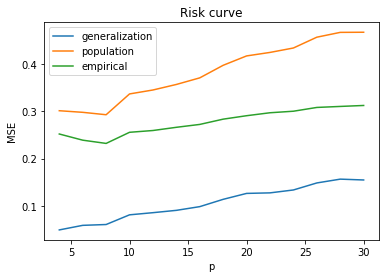

In [43]:
# plt.figure(figsize = (8,4))
x=range(4,32,2)
plt.plot(x, generalization_error,label='generalization')
plt.plot(x, population_error,label='population')
plt.plot(x, empirical_error,label='empirical')

plt.legend()
plt.xlabel('p')
plt.ylabel('MSE')
plt.title('Risk curve')
plt.show()

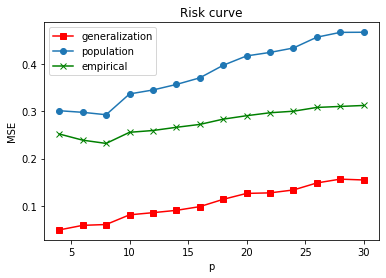

In [44]:
# plt.figure(figsize = (8,4))
x=range(4,32,2)
plt.plot(x, generalization_error,label='generalization',color='r',marker='s')
plt.plot(x, population_error,label='population',marker='o')
plt.plot(x, empirical_error,label='empirical',color='g',marker='x')

plt.legend()
plt.xlabel('p')
plt.ylabel('MSE')
plt.title('Risk curve')
plt.show()

### Tuning hyperparameters

In [45]:
generalization_error

array([0.04924196, 0.05890378, 0.06065875, 0.08114462, 0.08571064,
       0.0906315 , 0.09848377, 0.11393789, 0.12646767, 0.12760483,
       0.13373255, 0.14858859, 0.15664575, 0.15488047])

beta=10000,sigma_q=1
array([0.05290429, 0.03306365, 0.05025853, 0.06982479, 0.1009426 ,
       0.12618213, 0.17196009, 0.21863089, 0.26071406, 0.26533174,
       0.26107472, 0.27038095, 0.27900728, 0.28103048])
